In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ttest_ind

In [153]:
df = pd.read_spss('nilt23w1.sav')

In [151]:
df['RELIGCAT'] = pd.Categorical(df['RELIGCAT'], categories=['No religion', 'Catholic', 'Protestant'], ordered=True)

In [152]:
df = pd.get_dummies(df, columns=['RELIGCAT'], drop_first=True) 

In [133]:
df['catholic'] = df['RELIGCAT_Catholic']
df['protestant'] = df['RELIGCAT_Protestant']

In [134]:
# Function to map income ranges to midpoints
def map_income_range_to_value(income_range):
    if income_range == '£831 or more per week':
        return 831  
    elif income_range == '£511-£630 per week':
        return (511 + 630) / 2
    elif income_range == '£631-£831 per week':
        return (631 + 831) / 2
    elif income_range == '£421-£510 per week':
        return (421 + 510) / 2
    elif income_range == 'I don\'t know':
        return np.nan 
    elif income_range == '£241-£300 per week':
        return (241 + 300) / 2
    elif income_range == '£181-£240 per week':
        return (181 + 240) / 2
    elif income_range == '£361-£420 per week':
        return (361 + 420) / 2
    elif income_range == '£100-£180 per week':
        return (100 + 180) / 2
    elif income_range == '£301-£360 per week':
        return (301 + 360) / 2
    elif income_range == 'Less than £100 per week':
        return 100

# Apply the mapping function to the income range column
df['income'] = df['PERSINC3'].apply(map_income_range_to_value)

In [135]:
confidence_map = {
    "Not at all confident": 1,
    "Not very confident": 2,
    "Fairly confident": 3,
    "Very confident": 4
}
df['confidence'] = df['PPSFAIR'].map(confidence_map)

In [136]:
X = df[['catholic', 'protestant', 'income']]
X = X.dropna()
y = df['confidence']
y = y.dropna()

In [137]:
weights = df['WTFACTOR']
X, y = X.align(y, join='inner', axis=0)
X, weights = X.align(weights, join='inner', axis=0)
y, weights = y.align(weights, join='inner', axis=0) 

In [138]:
reg = LinearRegression().fit(X, y, sample_weight=weights)

In [139]:
features = {}
for f, c in zip(X.columns, reg.coef_):
    features[f] = c

In [140]:
features

{'catholic': np.float64(-0.022646949225994216),
 'protestant': np.float64(0.0688975625486948),
 'income': np.float64(0.0004865400898418931)}

In [141]:
catholic = df[df['catholic']]['confidence']
protestant = df[df['protestant']]['confidence']
catholic = catholic.dropna()
protestant = protestant.dropna()
t_stat, p_value = ttest_ind(catholic, protestant, equal_var=False)

In [142]:
r2 = r2_score(y, reg.predict(X))
print(f"R-squared: {r2:.4f}")

R-squared: 0.0162


In [143]:
mse = mean_squared_error(y, reg.predict(X))
print(f"Mean Squared Error: {mse:.4f}")
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.4f}")

Mean Squared Error: 0.5870
Root Mean Squared Error: 0.7661


In [144]:
# Compile results
results = {
    'r^2': f"{r2:.2%}",
    'mse': f"{mse:.2%}",
    'rmse': f"{rmse:.2%}",
    'T-Test Statistic': float(t_stat),
    'P-Value': float(p_value),
    'Significant (p < 0.05)': bool(p_value < 0.05)
}

results

{'r^2': '1.62%',
 'mse': '58.70%',
 'rmse': '76.61%',
 'T-Test Statistic': -0.4286348922639369,
 'P-Value': 0.6683405383928065,
 'Significant (p < 0.05)': False}

In [155]:
df['RELIGCAT'].value_counts()

RELIGCAT
Protestant     457
Catholic       398
No religion    300
Name: count, dtype: int64

In [156]:
df['PROTCATH'].value_counts()

PROTCATH
Part of the Protestant community    470
Part of the Catholic community      375
Neither                             342
Name: count, dtype: int64

In [158]:
df['URBRUR'].value_counts()

URBRUR
Urban    784
Rural    416
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Fairly safe'),
  Text(1, 0, 'Fairly unsafe'),
  Text(2, 0, "I don't know"),
  Text(3, 0, 'Neither safe nor unsafe'),
  Text(4, 0, 'Very safe'),
  Text(5, 0, 'Very unsafe')])

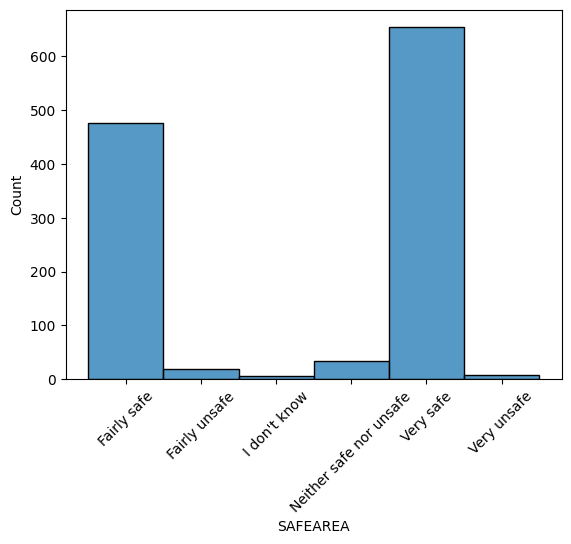

In [159]:
sns.histplot(df, x='SAFEAREA')
plt.xticks(rotation=45)

In [160]:
df['SAFEAREA'].value_counts()

SAFEAREA
Very safe                  654
Fairly safe                476
Neither safe nor unsafe     34
Fairly unsafe               20
Very unsafe                  8
I don't know                 6
Name: count, dtype: int64

In [165]:
df['POLPART2'].value_counts()

POLPART2
Alliance Party                               283
Sinn Féin                                    199
Democratic Unionist Party (DUP)              179
Ulster Unionist Party (UUP)                  123
None of these                                112
Social Democratic and Labour Party (SDLP)     97
I don't know                                  88
Green Party                                   41
Other Party (WRITE IN)                        35
Other answer (WRITE IN)                       17
Name: count, dtype: int64

In [170]:
cats = ['Very safe', 'Fairly safe', 'Neither safe nor unsafe', 'Fairly unsafe', 'Very unsafe', "I don't know"]
df['safe'] = pd.Categorical(df['SAFEAREA'], categories=cats, ordered=True)

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_7498/651471126.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  safe_area = df.groupby(['RELAREA', 'safe']).size().unstack()


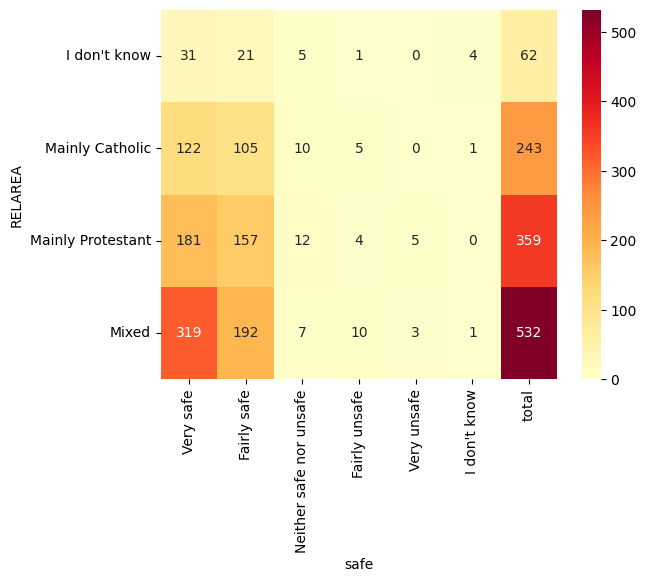

In [175]:
safe_area = df.groupby(['RELAREA', 'safe']).size().unstack()
safe_area['total'] = safe_area.sum(axis=1)
sns.heatmap(safe_area, annot=True, fmt='d', cmap='YlOrRd')
plt.savefig('heatmap1.png')
plt.show()


/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_7498/3522122295.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  law_justice = df.groupby(['RELAREA', 'AREALAWJ']).size().unstack()


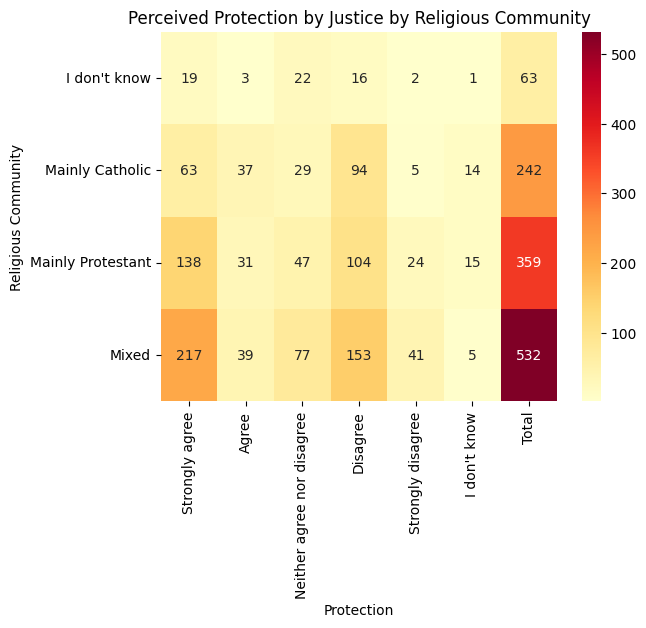

In [149]:
law_justice = df.groupby(['RELAREA', 'AREALAWJ']).size().unstack()
law_justice['total'] = law_justice.sum(axis=1)
labels = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "I don't know", 'Total']
sns.heatmap(law_justice, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perceived Protection by Justice by Religious Community')
plt.xlabel('Protection')
plt.ylabel('Religious Community')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_7498/3607664575.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  paramilitary_perception = df.groupby(['RELAREA', 'PGCONTRL']).size().unstack()


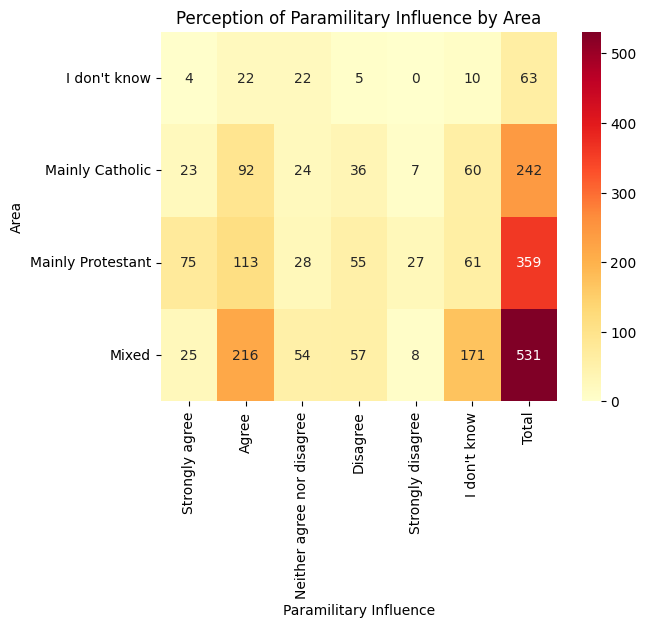

In [176]:
paramilitary_perception = df.groupby(['RELAREA', 'PGCONTRL']).size().unstack()
paramilitary_perception['total'] = paramilitary_perception.sum(axis=1)
sns.heatmap(paramilitary_perception, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Paramilitary Influence by Area')
plt.xlabel('Paramilitary Influence')
plt.ylabel('Area')
plt.savefig('heatmap2.png')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_7498/2533996254.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  paramilitary_perception = df.groupby(['COMMAREA', 'PGCONTRL']).size().unstack()


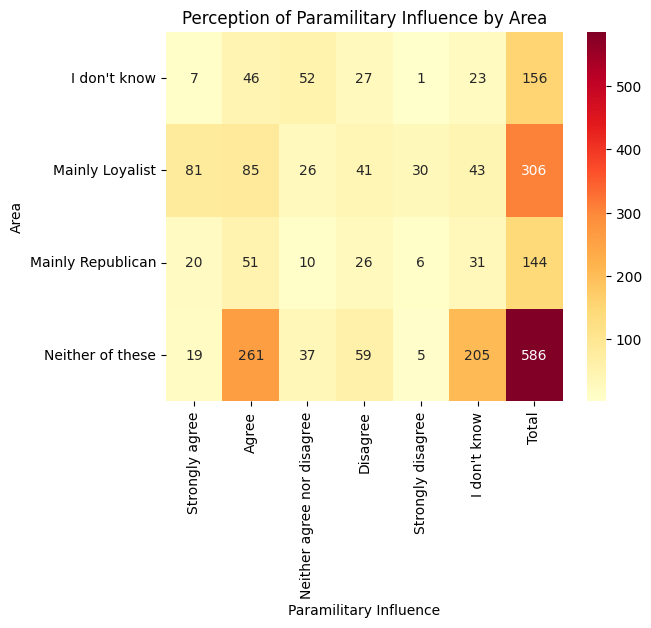

In [177]:
paramilitary_perception = df.groupby(['COMMAREA', 'PGCONTRL']).size().unstack()
paramilitary_perception['total'] = paramilitary_perception.sum(axis=1)
sns.heatmap(paramilitary_perception, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Paramilitary Influence by Area')
plt.xlabel('Paramilitary Influence')
plt.ylabel('Area')
plt.savefig('heatmap3.png')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_7498/510353917.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime = df.groupby(['RELAREA', 'YPCRIME']).size().unstack()


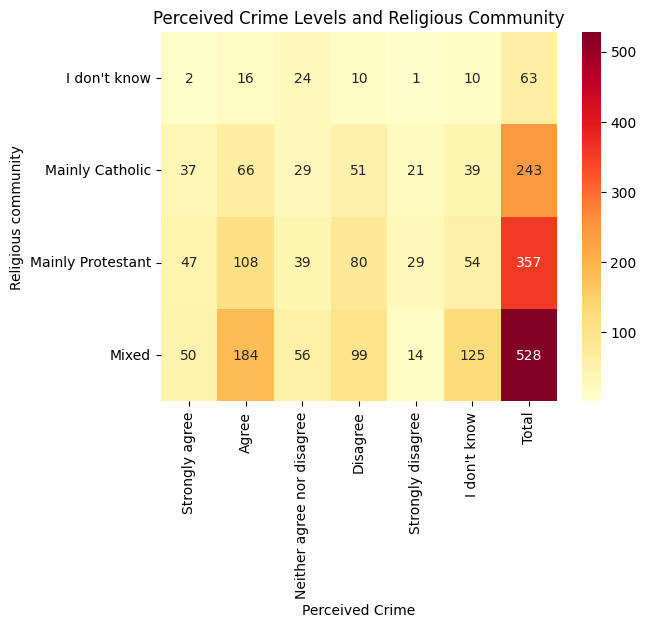

In [178]:
crime = df.groupby(['RELAREA', 'YPCRIME']).size().unstack()
crime['total'] = crime.sum(axis=1)
sns.heatmap(crime, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perceived Crime Levels and Religious Community')
plt.xlabel('Perceived Crime')
plt.ylabel('Religious community')
plt.savefig('heatmap4.png')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2548986188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  victims = df.groupby(['RELIGCAT', 'VICTCJS']).size().unstack()


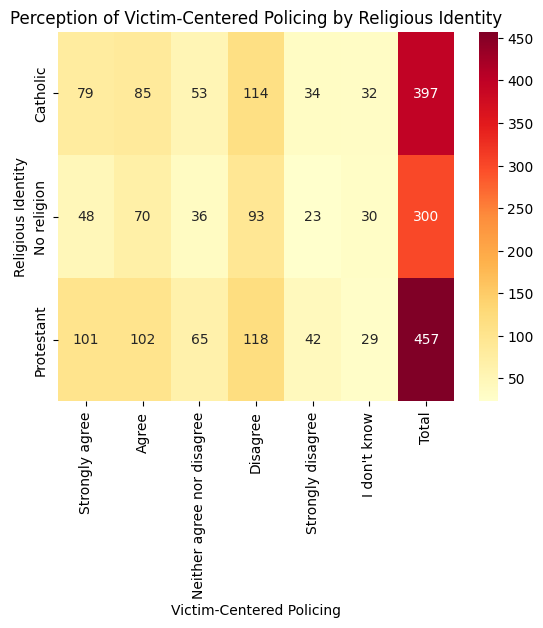

In [81]:
victims = df.groupby(['RELIGCAT', 'VICTCJS']).size().unstack()
victims['total'] = victims.sum(axis=1)
sns.heatmap(victims, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Victim-Centered Policing by Religious Identity')
plt.xlabel('Victim-Centered Policing')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2233746734.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fair = df.groupby(['RELIGCAT', 'PPSFAIR']).size().unstack()


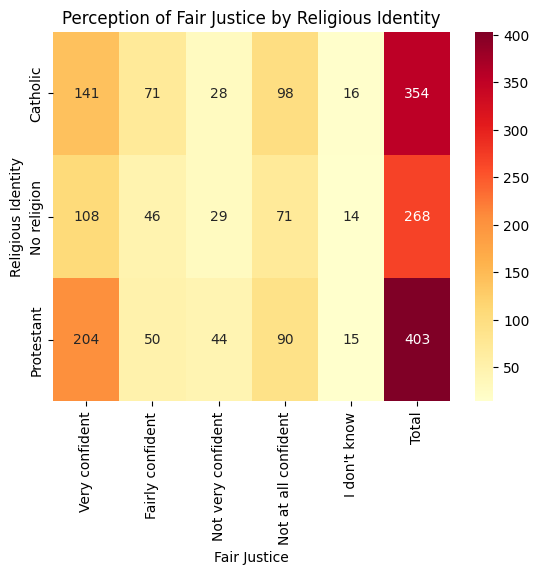

In [92]:
fair = df.groupby(['RELIGCAT', 'PPSFAIR']).size().unstack()
fair['Total'] = fair.sum(axis=1)
labels = ['Very confident', 'Fairly confident', 'Not very confident', 'Not at all confident', "I don't know", 'Total']
sns.heatmap(fair, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Fair Justice by Religious Identity')
plt.xlabel('Fair Justice')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2556331095.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ind = df.groupby(['RELIGCAT', 'PPSINDP']).size().unstack()


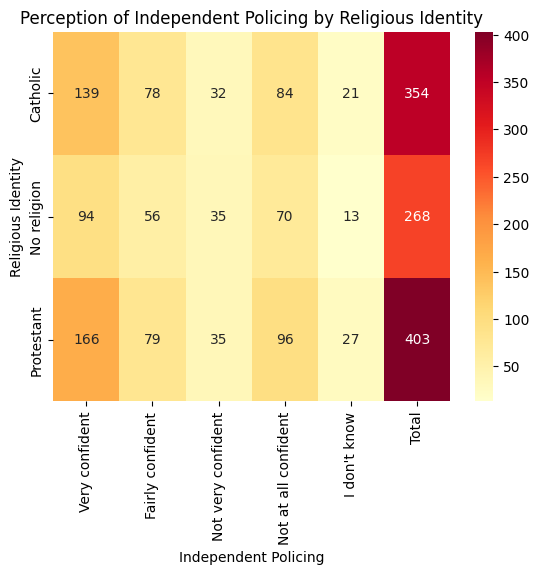

In [94]:
ind = df.groupby(['RELIGCAT', 'PPSINDP']).size().unstack()
ind['total'] = ind.sum(axis=1)
sns.heatmap(ind, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Independent Policing by Religious Identity')
plt.xlabel('Independent Policing')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/841010574.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  poimpart = df.groupby(['RELIGCAT', 'POIMPART']).size().unstack()


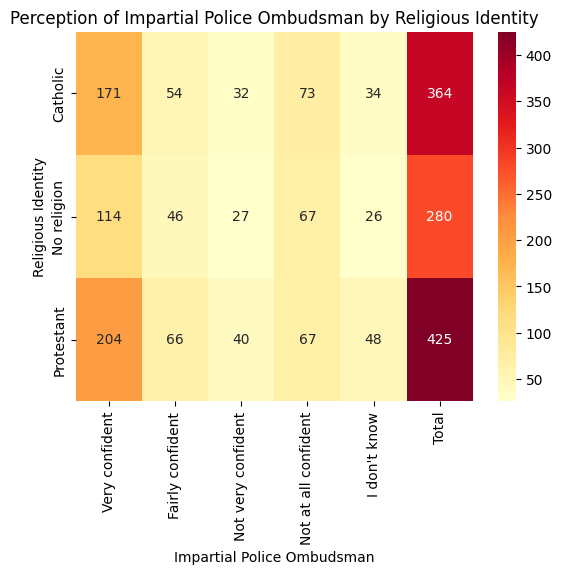

In [ ]:
poimpart = df.groupby(['RELIGCAT', 'POIMPART']).size().unstack()
poimpart['total'] = poimpart.sum(axis=1)
sns.heatmap(poimpart, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Perception of Impartial Police Ombudsman by Religious Identity')
plt.xlabel('Impartial Police Ombudsman')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/132201629.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pofair = df.groupby(['RELIGCAT', 'POFAIR']).size().unstack()


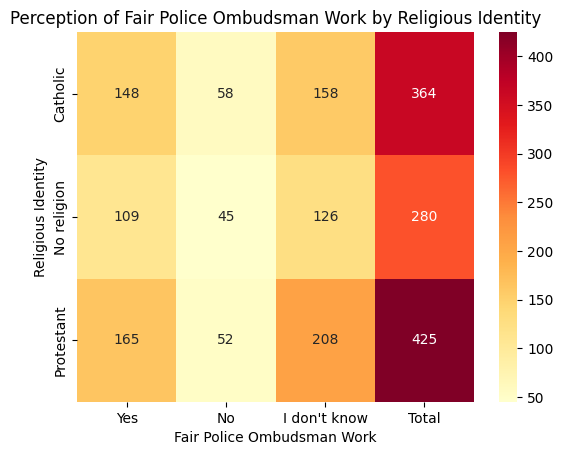

In [99]:
pofair = df.groupby(['RELIGCAT', 'POFAIR']).size().unstack()
pofair['total'] = pofair.sum(axis=1)
sns.heatmap(pofair, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Yes', 'No', "I don't know", 'Total'])
plt.title('Perception of Fair Police Ombudsman Work by Religious Identity')
plt.xlabel('Fair Police Ombudsman Work')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/2247016809.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pogoodjob = df.groupby(['RELIGCAT', 'POGOODJB']).size().unstack()


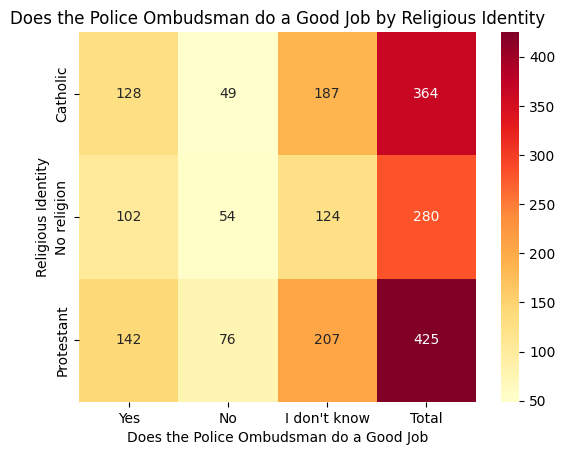

In [102]:
pogoodjob = df.groupby(['RELIGCAT', 'POGOODJB']).size().unstack()
pogoodjob['total'] = pogoodjob.sum(axis=1)
sns.heatmap(pogoodjob, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Yes', 'No', "I don't know", 'Total'])
plt.title('Does the Police Ombudsman do a Good Job by Religious Identity')
plt.xlabel('Does the Police Ombudsman do a Good Job')
plt.ylabel('Religious Identity')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_12419/3910394652.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confident = df.groupby(['RELAREA', 'AREAREPC']).size().unstack()


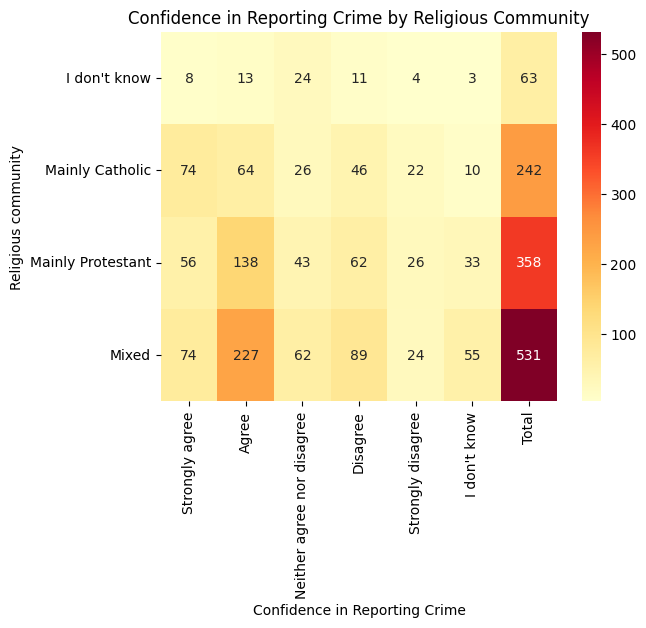

In [104]:
confident = df.groupby(['RELAREA', 'AREAREPC']).size().unstack()
confident['total'] = confident.sum(axis=1)
labels = ['Strongly agree', 'Agree', 'Neither agree nor disagree', 'Disagree', 'Strongly disagree', "I don't know", 'Total']
sns.heatmap(confident, annot=True, fmt='d', cmap='YlOrRd', xticklabels=labels)
plt.title('Confidence in Reporting Crime by Religious Community')
plt.xlabel('Confidence in Reporting Crime')
plt.ylabel('Religious community')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_5413/2343064000.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  crime_reporting = df.groupby(['RELIGCAT', 'REPBURG']).size().unstack()


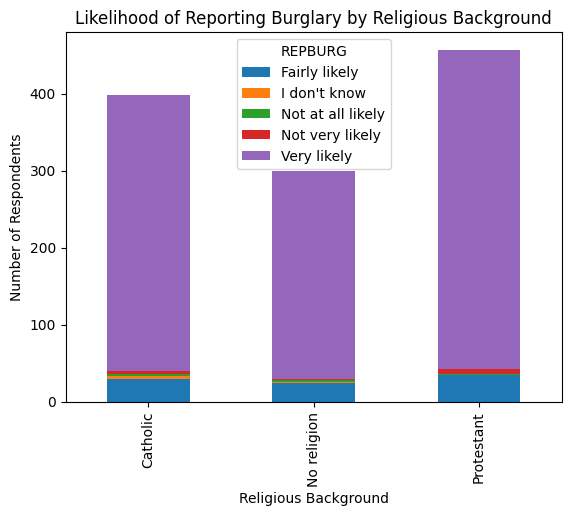

In [9]:
crime_reporting = df.groupby(['RELIGCAT', 'REPBURG']).size().unstack()
crime_reporting.plot(kind='bar', stacked=True)
plt.title('Likelihood of Reporting Burglary by Religious Background')
plt.xlabel('Religious Background')
plt.ylabel('Number of Respondents')
plt.show()

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_5413/573184782.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pps_confidence = df.groupby(['RELIGCAT', 'PPSEFF']).size().unstack()


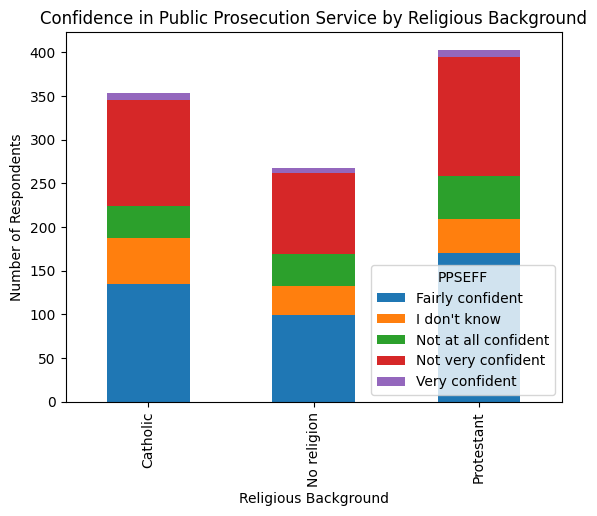

In [10]:
pps_confidence = df.groupby(['RELIGCAT', 'PPSEFF']).size().unstack()
pps_confidence.plot(kind='bar', stacked=True)
plt.title('Confidence in Public Prosecution Service by Religious Background')
plt.xlabel('Religious Background')
plt.ylabel('Number of Respondents')
plt.show()

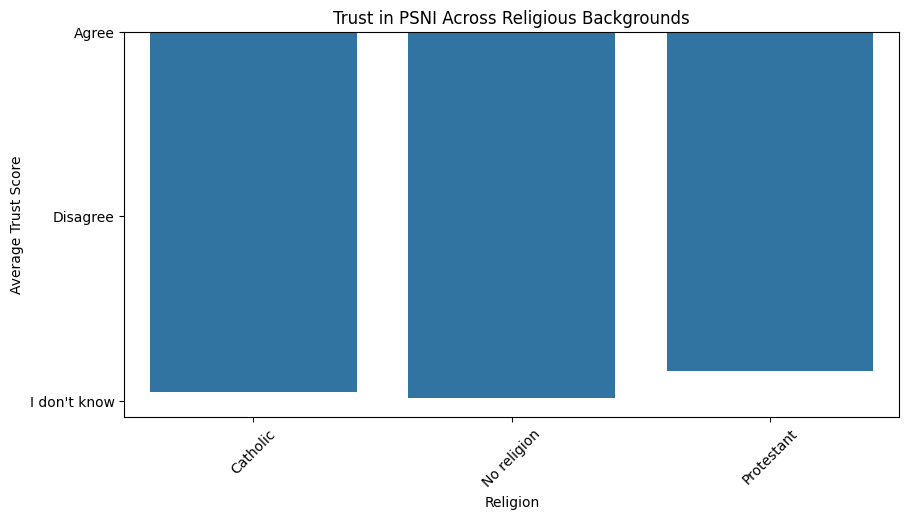

In [16]:
plt.figure(figsize=(10, 5))
sns.barplot(x="RELIGCAT", y="PSNISAFE", data=df, estimator=lambda x: sum(x) / len(x), errorbar=None)
plt.xticks(rotation=45)
plt.title("Trust in PSNI Across Religious Backgrounds")
plt.ylabel("Average Trust Score")
plt.xlabel("Religion")
plt.show()